In [97]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as pl
%matplotlib inline

In [98]:
# set parameters

# cross-section in units-squared
sigma = 20
# number of particles 
N = 500
# size of box
l = 100
# maximum start velocity
maxv = 10
# timestep
dt = 0.1
# particle mass
m1 = 1
m2 = 1

In [99]:
# set initial conditions 

# radius of a particle
r = np.sqrt(sigma/np.pi)
# random positions assuming square box of side-length l reaching from the origin to (x,y) = (l,l)
x = np.random.rand(N)*l
y = np.random.rand(N)*l
# random velocities
v = np.random.rand(N)*maxv
theta = np.random.rand(N)*2*np.pi
vx = v*np.cos(theta)
vy = v*np.sin(theta)
# random masses
condition = np.floor(np.random.rand(N)*2)
m = np.array([m1 if c else m2 for c in condition])

In [100]:
# function to enforce hard wall boundary conditions - does not conserve momentum in collisions with walls
def hard_wall(x, y, vx, vy):
    out = outside(x, y)
    if not out:
        return vx, vy
    if out == 1 or out == 2:
        return -vx, vy
    if out == 3 or out == 4:
        return vx, -vy

# function to enforce periodic boundaries
def periodic(x, y):
    out = outside(x, y)
    if not out:
        return x, y
    if out == 1 or out == 2:
        return x % l, y
    if out == 3 or out == 4:
        return x, y % l
    
# returns zero if the coordinates are inside the simulation space, and 1, 2, 3, or 4 if the particle is 
# outside the left, right, top, or bottom boundary respectively. 
def outside(x, y):
    if x < 0:
        return 1
    if x > l:
        return 2
    if y > l: 
        return 3
    if y < 0: 
        return 4
    
# function to check for collisions
def coll_check(x1, y1, x2, y2):
    if dist(x1, y1, x2, y2) < r:
        return True
    else: 
        return False

# computes distance between two points
def dist(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2. + (y1 - y2)**2.)

# plot the particle positions and velocity distribution
def plot_sim(x, y, vx, vy):
    fig = pl.figure(figsize = (20, 4))
    pl.subplot(131)
    pl.hist(np.sqrt(vx*vx + vy*vy), bins=20);
    pl.xlabel('velocity')
    pl.ylabel('N(v)')
    pl.title('velocity distribution')
    pl.subplot(132)
    pl.plot(x, y, '.')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.title('particle positions')

def collide(x1, x2, y1, y2, vx1, vx2, vy1, vy2, m1, m2):
    theta = np.arctan((y1-y2)/(x1-x2))
    vi_norm = vx1*np.cos(theta) + vy1*np.sin(theta)
    vj_norm = vx2*np.cos(theta) + vy2*np.sin(theta)
    vi_tan = vx1*np.sin(theta) - vy1*np.cos(theta)
    vj_tan = vx2*np.sin(theta) - vy2*np.cos(theta)
    vi_norm_tmp = vi_norm
    vi_norm = m2*vj_norm/m1
    vj_norm = m1*vi_norm_tmp/m2
    vx1 = vi_norm*np.cos(theta) + vi_tan*np.sin(theta)
    vy1 = vi_norm*np.sin(theta) - vi_tan*np.cos(theta)
    vx2 = vj_norm*np.cos(theta) + vj_tan*np.sin(theta)
    vy2 = vj_norm*np.sin(theta) - vj_tan*np.cos(theta)
    return vx1, vx2, vy1, vy2
    
    
# run the simulation and return the linear pressure at each step
def step(x, y, vx, vy):
    pressure = 0
    for i in range(len(x)):
        # hard wall boundary conditions
        #vx[i], vy[i] = hard_wall(x[i], y[i], vx[i], vy[i])
        # periodic boundary conditions
        if outside(x[i], y[i]) == 2:
            pressure += np.abs(2*m[i]*vx[i])
        x[i], y[i] = periodic(x[i], y[i])
        for j in range(i):
            if coll_check(x[i], y[i], x[j], y[j]):
                vx[i], vx[j], vy[i], vy[j] = collide(x[i], x[j], y[i], y[j], vx[i], vx[j], vy[i], vy[j], m[i], m[j])   
        # step particle positions        
        x[i] += vx[i]*dt
        y[i] += vy[i]*dt
    return pressure/(l*dt)

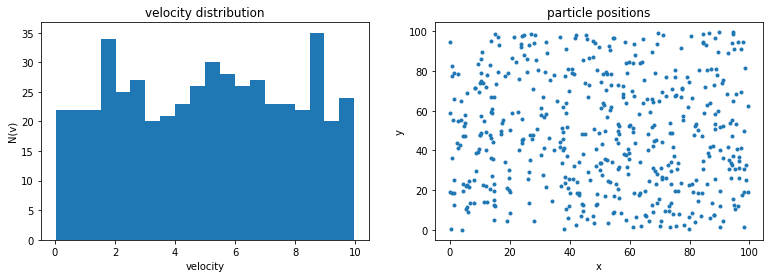

In [101]:
# plot initial configuration
plot_sim(x, y, vx, vy)

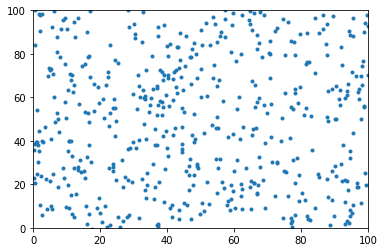

In [102]:
# animate particle motions

from matplotlib import animation

fig = pl.figure()
ax = pl.axes(xlim=(0, 100), ylim=(0, 100))
line, = ax.plot([], [], '.')

def init():
    line.set_data([],[])
    return line,

def animate(i):
    pressure.append(step(x, y, vx, vy))
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=20, blit=True)
anim.save('particles.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [104]:
# compute temperature and pressure. Modify for density by looping over side-lengths rather than max velocity.
temps = []
vels = np.linspace(2, 20, 1)
pressure = []
for maxv in vels:
    v = np.random.rand(N)*maxv
    theta = np.random.rand(N)*2*np.pi
    vx = v*np.cos(theta)
    vy = v*np.sin(theta)
    p = 0
    for i in range(100):
        p += step(x, y, vx, vy)
    kT = np.sum(0.5*v*v*m)
    temps.append(kT)
    pressure.append(p/100)

Text(0,0.5,'Pressure (dyn/cm$^{-2}$)')

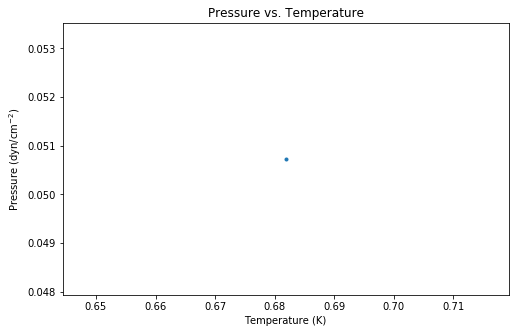

In [105]:
# plot temperature vs. pressure. Modify this for density vs. pressure.
fig = pl.figure(figsize=(8, 5))
pl.plot(np.array(temps)/N, pressure, '.')
pl.title('Pressure vs. Temperature')
pl.xlabel('Temperature (K)')
pl.ylabel(r'Pressure (dyn/cm$^{-2}$)')

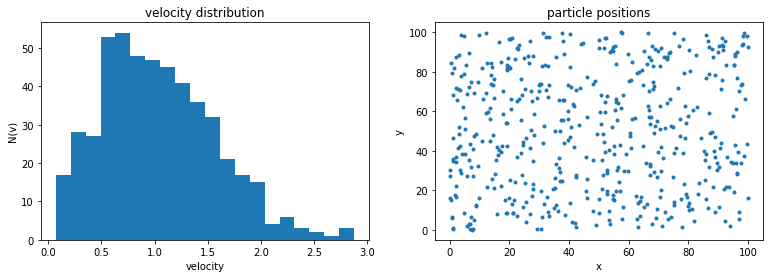

In [106]:
# plot final configuration
plot_sim(x, y, vx, vy)

In [109]:
# make a smooth histogram by running a bunch of simulations
N = 100

velocities = []
def sample_velocity(n, check):
    # random positions
    x = np.random.rand(N)*l
    y = np.random.rand(N)*l
    # random velocities
    v = np.random.rand(N)*maxv
    theta = np.random.rand(N)*2*np.pi
    vx = v*np.cos(theta)
    vy = v*np.sin(theta)
    for i in range(n):
        step(x, y, vx, vy)
        if i % check == 0:
            velocities.append([vx, vy])
            # random positions assuming square box of side-length l reaching from the origin to (x,y) = (l,l)
            x = np.random.rand(N)*l
            y = np.random.rand(N)*l
            # random velocities
            v = np.random.rand(N)*maxv
            theta = np.random.rand(N)*2*np.pi
            vx = v*np.cos(theta)
            vy = v*np.sin(theta)
            # random masses
            condition = np.floor(np.random.rand(N)*2)
            m = np.array([m1 if c else m2 for c in condition])
            
sample_velocity(5000, 100)

In [ ]:
# plot smooth histograms with analytic maxwellians. 

import scipy.constants as c

def maxwellian(v, T, m, N):
    return N*m*v*np.exp(-m*v*v/(c.k*1e24*T))/(c.k*1e24*T)

fig = pl.figure(figsize=(10, 10))

v = np.array(velocities)
vx = np.concatenate(v[:,0])
vy = np.concatenate(v[:,1])
bins = pl.hist(np.sqrt(vx*vx + vy*vy), bins=20, label='simulation data');
v = np.linspace(0, 20, 1000)
pl.plot(v, maxwellian(v, 2.47, 1, 12000), label='maxwellian with m=10')
pl.title('Velocity Distribution for 100 particles')
pl.xlabel('velocity')
pl.ylabel('N(v)')
pl.legend()
print(4*4/(2*c.k*1e24))
print(len(vx))

In [ ]:
# test the relaxation time numerically by comparing two halves of the velocity distribution to see that it follows 
# a Maxwellian

from scipy.stats import mode

def is_relaxed(vx, vy):
    v = np.sqrt(vx*vx + vy*vy)
    bins = np.linspace(min(v), max(v), 20)
    max_bin = mode(np.digitize(v, bins=bins))[0][0]
    mid = np.sqrt(2*np.log(2))*(bins[max_bin] + bins[max_bin-1])/2
    pop_low = len(v[v < mid])
    diff = 2-N/pop_low
    return np.abs(diff) < 0.1

In [ ]:
# compute the relaxation time by stepping until the is_relaxed condition is met

def relax_time():
    relaxed = False
    i = 0
    while not relaxed:
        step(x, y, vx, vy)
        i += 1
        if is_relaxed(vx, vy):
            relaxed = True
    return i

In [ ]:
fig = pl.figure(figsize=(8, 5))

pl.plot(np.arange(0.5, 2, 0.1), dt*np.array(times), 'o', label='Time for velocity distribution to become Maxwellian')
r = np.sqrt(20/np.pi)
r = np.linspace(0.5, 2, 1000)
dens = 1/100
pl.plot(r, 1./(2*r*dens*np.median(v)), label='Theoretical time between collisions')

pl.legend()
pl.title('Relaxation Time vs. Particle Radius')
pl.xlabel('Particle Radius (nm)')
pl.ylabel('Relaxation Time (Seconds)')